In [1]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [2]:
!unzip /content/drive/MyDrive/pokemon.zip

Streaming output truncated to the last 5000 lines.
 extracting: pokemon/601/601-0.png   
 extracting: pokemon/601/601-49.png  
 extracting: pokemon/601/601-55.png  
 extracting: pokemon/601/601-45.png  
 extracting: pokemon/601/601-27.png  
 extracting: pokemon/601/601-78.png  
 extracting: pokemon/601/601-41.png  
 extracting: pokemon/601/601-8.png   
 extracting: pokemon/601/601-43.png  
 extracting: pokemon/601/601-20.png  
 extracting: pokemon/601/601-58.png  
 extracting: pokemon/601/601-19.png  
 extracting: pokemon/601/601-28.png  
 extracting: pokemon/601/601-69.png  
 extracting: pokemon/601/601-75.png  
 extracting: pokemon/601/601-17.png  
 extracting: pokemon/601/601-1.png   
 extracting: pokemon/601/601-30.png  
 extracting: pokemon/601/601-26.png  
 extracting: pokemon/601/601-21.png  
 extracting: pokemon/601/601-76.png  
 extracting: pokemon/601/601-5.png   
 extracting: pokemon/601/601-62.png  
 extracting: pokemon/601/601-4.png   
 extracting: pokemon/601/601-50.png  

In [3]:
import os
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

In [4]:
class Discriminator(nn.Module):
  def __init__(self,channel_img,feature_d):
    super(Discriminator,self).__init__()
    self.disc=nn.Sequential(
            nn.Conv2d(channel_img,feature_d,4,2,1),
            nn.LeakyReLU(0.2),
            self._block(feature_d,feature_d*2,4,2,1),#16
            self._block(feature_d*2,feature_d*4,4,2,1),#8
            self._block(feature_d*4,feature_d*8,4,2,1),#4
            nn.Conv2d(feature_d*8,1,4,1,0),
            nn.Sigmoid()
        )
  def _block(self,in_channel,out_channel,kernal_size,stride,padding):
    return nn.Sequential(nn.Conv2d(in_channel,out_channel,kernal_size,stride,padding,bias=False),
    nn.BatchNorm2d(out_channel),
    nn.LeakyReLU(0.2)
    )
  def forward(self,x):
    return self.disc(x)


class Generator(nn.Module):
  def __init__(self,z_dim,channel_img,feature_g):
    super(Generator,self).__init__()
    self.gen= nn.Sequential(
        self._block(z_dim,feature_g*16,4,2,0),
        self._block(feature_g*16,feature_g*8,4,2,1),
        self._block(feature_g*8,feature_g*4,4,2,1),
        self._block(feature_g*4,feature_g*2,4,2,1),
        nn.ConvTranspose2d(feature_g*2,channel_img,4,2,1),
        nn.Tanh()
    )
  def _block(self,in_channel,out_channel,kernal_size,stride,padding):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channel,out_channel,kernal_size,stride,padding,bias=False),
        nn.BatchNorm2d(out_channel),
        nn.ReLU()
    )
  def forward(self,x):
    return self.gen(x)

In [5]:
class PokemonDataset(Dataset):
  def __init__(self,path,transform=None):
    self.data=ImageFolder(path,transform=transform)
  def __len__(self):
    return len(self.data)
  def __getitem__(self,idx):
    return self.data[idx]
  def classes(self):
    return self.data.classes

In [6]:
device =torch.device("cuda" if torch.cuda.is_available() else "cpu")
lr=2e-4
batch_size=128
z_dim=100
img_size=64
channel_image=3
feature_d=64
feature_g=64
num_epoch=5

transform = transforms.Compose(
    [
      transforms.Resize((64,64)),
      transforms.ToTensor(),
      transforms.Normalize(
        [0.5 for _ in range(channel_image)],[0.5 for _ in range(channel_image)]),
    ]
)

In [7]:
from torchvision import datasets
from torchvision.datasets import ImageFolder
data_path = '/content/pokemon'
dataset=PokemonDataset(data_path,transform=transform)
dataloader=DataLoader(dataset,batch_size=128,shuffle=True)
z=torch.randn(batch_size,z_dim,1,1).to(device)

In [14]:
print(len(dataloader))

def intialize_weight(model):
  for m in model.modules():
    if isinstance(m,(nn.Conv2d,nn.ConvTranspose2d,nn.BatchNorm2d)):
      nn.init.normal_(m.weight.data,0.0,0.02)

gen=Generator(z_dim,channel_image,feature_g).to(device)
des=Discriminator(channel_image,feature_d).to(device)
intialize_weight(gen)
intialize_weight(des)
opt_gen=torch.optim.Adam(gen.parameters(),lr=lr,betas=(0.5,0.999))
opt_des=torch.optim.Adam(des.parameters(),lr=lr,betas=(0.5,0.999))
criterion=nn.BCELoss()

318


In [16]:
import torchvision
for epochs in range(num_epoch):
  for batch_idx,(real,_) in enumerate(dataloader):
    real=real.to(device)
    z=torch.randn(batch_size,z_dim,1,1).to(device)
    disc_real=des(real).reshape(-1)
    loss_real=criterion(disc_real,torch.ones_like(disc_real))
    fake=gen(z)
    disc_fake=des(fake).reshape(-1)
    loss_fake=criterion(disc_fake,torch.zeros_like(disc_fake))
    loss_disc=(loss_real+loss_fake)/2
    opt_des.zero_grad()
    loss_disc.backward(retain_graph=True)
    opt_des.step()
    output=des(fake).reshape(-1)
    loss_gen=criterion(output,torch.ones_like(output))
    opt_gen.zero_grad()
    loss_gen.backward()
    opt_gen.step()
    if batch_idx%100==0:
      print(f'Epoch [{epochs}/{num_epoch}] Batch {batch_idx}/{len(dataloader)} Loss D: {loss_disc:.4f}, Loss G: {loss_gen:.4f}')

Epoch [0/5] Batch 0/318 Loss D: 0.6355, Loss G: 0.8871
Epoch [0/5] Batch 100/318 Loss D: 0.0164, Loss G: 4.1564
Epoch [0/5] Batch 200/318 Loss D: 0.3121, Loss G: 2.1635
Epoch [0/5] Batch 300/318 Loss D: 1.5020, Loss G: 3.3840
Epoch [1/5] Batch 0/318 Loss D: 0.2358, Loss G: 2.6301
Epoch [1/5] Batch 100/318 Loss D: 0.2481, Loss G: 2.8691
Epoch [1/5] Batch 200/318 Loss D: 0.4870, Loss G: 1.8160
Epoch [1/5] Batch 300/318 Loss D: 0.3409, Loss G: 2.4951
Epoch [2/5] Batch 0/318 Loss D: 0.3438, Loss G: 2.4389
Epoch [2/5] Batch 100/318 Loss D: 0.4926, Loss G: 2.2050
Epoch [2/5] Batch 200/318 Loss D: 0.3973, Loss G: 3.4452
Epoch [2/5] Batch 300/318 Loss D: 0.4098, Loss G: 1.6877
Epoch [3/5] Batch 0/318 Loss D: 0.5226, Loss G: 1.6115
Epoch [3/5] Batch 100/318 Loss D: 0.4886, Loss G: 1.7316
Epoch [3/5] Batch 200/318 Loss D: 0.4603, Loss G: 1.9083
Epoch [3/5] Batch 300/318 Loss D: 0.4468, Loss G: 3.0222
Epoch [4/5] Batch 0/318 Loss D: 0.4668, Loss G: 2.7919
Epoch [4/5] Batch 100/318 Loss D: 0.4084,

torch.Size([16, 3, 64, 64])


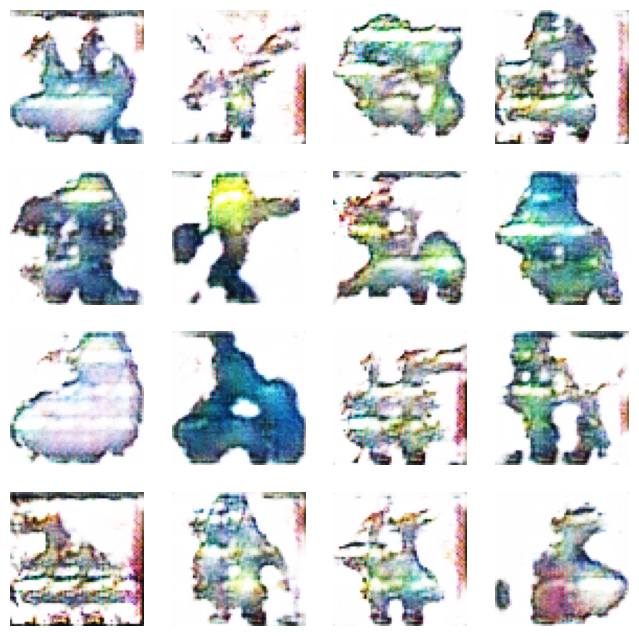

In [17]:
import matplotlib.pyplot as plt
def generate_and_visualize(generator, num_samples=1, noise_dim=100):
    noise = torch.randn(num_samples, noise_dim ,1,1).to(device)
    with torch.no_grad():
        fake_images = generator(noise)
    print(fake_images.shape)
    fake_images = fake_images.view(num_samples, 3, 64, 64).permute(0, 2, 3, 1).cpu().numpy()

    fig, axes = plt.subplots(4, 4, figsize=(8, 8))
    axes = axes.flatten()
    for i in range(num_samples):
        axes[i].imshow((fake_images[i] + 1) / 2)
        axes[i].axis('off')
    plt.show()

generate_and_visualize(gen, num_samples=16, noise_dim=100)